# DESeq2
# Phase 1 vs. Phase 1

focusing on pairwise comparisons involving oysters that experienced only **one** phase 1 (one exposure)

## 0. load libraries

In [107]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(vegan)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts <- counts %>%
select(-Gene_ID, -Length)

head(counts)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


### meta data

In [4]:
# create df with col names from counts matrix
meta <- as.data.frame(colnames(counts))

colnames(meta) <- 'Sample'

# Separate into columns
meta <- meta %>%
   # Keep original SampleID
  mutate(OGSample = Sample) %>%
  # Split by '_'
  separate(Sample, into = c("Phase1", "Phase2", "Tag"), sep = "_") %>%
  mutate(
    Phase1_Treatment = substr(Phase1, 1, 1),
    Phase1_TankRep    = as.numeric(substr(Phase1, 2, nchar(Phase1))),
    Phase2_Treatment = gsub("[0-9]", "", Phase2),
    Phase2_TankRep       = as.numeric(gsub("[A-Za-z]", "", Phase2))
  ) %>%
  select(OGSample, Phase1_Treatment, Phase1_TankRep, Phase2_Treatment, Phase2_TankRep, Tag)

colnames(meta)[1] <- 'Sample'

head(meta)

,Sample,Phase1_Treatment,Phase1_TankRep,Phase2_Treatment,Phase2_TankRep,Tag
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,B1_B1_O01,B,1,B,1,O01
2,B1_Nu_O03,B,1,Nu,NA,O03
3,B1_W5_O50,B,1,W,5,O50
4,B2_B5_O51,B,2,B,5,O51
5,B2_C4_O40,B,2,C,4,O40
6,B2_Nu_O12,B,2,Nu,NA,O12


In [5]:
# adding treatment info
meta2 <- meta %>%
mutate(
    ## phase 1 treatments
    # overall
    Phase1_treatment = case_when(
        Phase1_Treatment == 'B' ~ 'both',
        Phase1_Treatment == 'H' ~ 'hypoxic',
        Phase1_Treatment == 'W' ~ 'warm',
        Phase1_Treatment == 'C' ~ 'control',
    TRUE ~ NA_character_),
    
    # temp
    Phase1_temp = case_when(
        Phase1_Treatment == 'B' ~ 'warm',
        Phase1_Treatment == 'H' ~ 'ambient',
        Phase1_Treatment == 'W' ~ 'warm',
        Phase1_Treatment == 'C' ~ 'ambient',
    TRUE ~ NA_character_),

    # dissolved oxygen
    Phase1_DO = case_when(
        Phase1_Treatment == 'B' ~ 'hypoxic',
        Phase1_Treatment == 'H' ~ 'hypoxic',
        Phase1_Treatment == 'W' ~ 'normoxic',
        Phase1_Treatment == 'C' ~ 'normoxic',
    TRUE ~ NA_character_),
    
    ## phase 2 treatments
    # overall
    Phase2_treatment = case_when(
        Phase2_Treatment == 'B' ~ 'both',
        Phase2_Treatment == 'H' ~ 'hypoxic',
        Phase2_Treatment == 'W' ~ 'warm',
        Phase2_Treatment == 'C' ~ 'control',
    TRUE ~ NA_character_),
    
    # temp
    Phase2_temp = case_when(
        Phase2_Treatment == 'B' ~ 'warm',
        Phase2_Treatment == 'H' ~ 'ambient',
        Phase2_Treatment == 'W' ~ 'warm',
        Phase2_Treatment == 'C' ~ 'ambient',
    TRUE ~ NA_character_),

    # dissolved oxygen
    Phase2_DO = case_when(
        Phase2_Treatment == 'B' ~ 'hypoxic',
        Phase2_Treatment == 'H' ~ 'hypoxic',
        Phase2_Treatment == 'W' ~ 'normoxic',
        Phase2_Treatment == 'C' ~ 'normoxic',
    TRUE ~ NA_character_)) %>%
select(Sample, Phase1_treatment, Phase1_temp, Phase1_DO, Phase1_TankRep, Phase2_treatment, Phase2_temp, Phase2_DO, Phase2_TankRep)

head(meta2)

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
2,B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
3,B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
4,B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
5,B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
6,B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA


In [41]:
write.csv(meta2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv')

for this analysis, only looking at Phase 1 samples, so pulling those out

In [6]:
# if skipped above code:
meta2 <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv')

In [7]:
# selecting only phase 1 sample
p1_meta <- meta2 %>%
filter(grepl("Nu", Sample)) %>%
filter(Sample != 'B3_Nu_O24') # this sample failed all QC steps, removing from analysis

# setting samples as rownames and deleting col from df
rownames(p1_meta) <- p1_meta$Sample
p1_meta <- p1_meta[, !colnames(p1_meta) %in% "Sample"]

p1_meta

,X,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_Nu_O03,2,both,warm,hypoxic,1,NA,NA,NA,NA
B2_Nu_O12,6,both,warm,hypoxic,2,NA,NA,NA,NA
B4_Nu_O32,19,both,warm,hypoxic,4,NA,NA,NA,NA
B5_Nu_O36,25,both,warm,hypoxic,5,NA,NA,NA,NA
B6_Nu_O47,30,both,warm,hypoxic,6,NA,NA,NA,NA
C1_Nu_W01,35,control,ambient,normoxic,1,NA,NA,NA,NA
C1_Nu_W05,36,control,ambient,normoxic,1,NA,NA,NA,NA
C2_Nu_W15,40,control,ambient,normoxic,2,NA,NA,NA,NA
C3_Nu_W21,44,control,ambient,normoxic,3,NA,NA,NA,NA


In [8]:
# pulling out only phase 1 counts
p1_counts <- counts[,colnames(counts) %in% rownames(p1_meta)]
head(p1_counts)

,B1_Nu_O03,B2_Nu_O12,B4_Nu_O32,B5_Nu_O36,B6_Nu_O47,C1_Nu_W01,C1_Nu_W05,C2_Nu_W15,C3_Nu_W21,C4_Nu_W29,⋯,H3_Nu_B18,H4_Nu_B28,H5_Nu_B35,H6_Nu_B45,W1_Nu_G02,W2_Nu_G15,W3_Nu_G21,W4_Nu_G27,W6_Nu_G41,W6_Nu_G45
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,1,16,13,11,1,16,2,1,2,10,⋯,16,29,15,0,3,23,12,9,1,2
LOC111126949,652,523,444,1438,609,525,1076,541,566,613,⋯,451,608,745,394,1362,1235,270,407,492,330
LOC111110729,209,177,207,154,184,148,144,161,155,259,⋯,136,151,221,143,231,64,91,140,118,115
LOC111112434,7,2,10,19,18,11,17,21,18,18,⋯,6,6,25,5,24,0,10,7,22,0
LOC111120752,586,417,388,202,330,848,236,156,699,712,⋯,278,406,282,230,430,458,929,433,621,251
LOC111128944,0,0,0,0,0,0,2,4,0,6,⋯,14,2,0,0,2,0,4,0,0,1


In [9]:
# setting the same order for counts matrix and meta data
p1_counts <- p1_counts[,rownames(p1_meta)]
all(rownames(p1_meta) == colnames(p1_counts))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [10]:
# overall phase 1 treatment
p1_meta$Phase1_treatment <- factor(p1_meta$Phase1_treatment,
                                   levels = c('control', 'both', 'hypoxic', 'warm'))

In [11]:
# phase 1 tempature
p1_meta$Phase1_temp <- factor(p1_meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

In [12]:
# phase 1 DO
p1_meta$Phase1_DO <- factor(p1_meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

### phase 1 overall treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [53]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = p1_counts,
                              colData = p1_meta,
                              design = ~ Phase1_treatment)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

class: DESeqDataSet 
dim: 38838 23 
metadata(1): version
assays(1): counts
rownames(38838): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(23): B1_Nu_O03 B2_Nu_O12 ... W6_Nu_G41 W6_Nu_G45
colData names(9): X Phase1_treatment ... Phase2_DO Phase2_TankRep

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                           "Phase1_treatment_both_vs_control"   
[3] "Phase1_treatment_hypoxic_vs_control" "Phase1_treatment_warm_vs_control"

### diagnostic tests

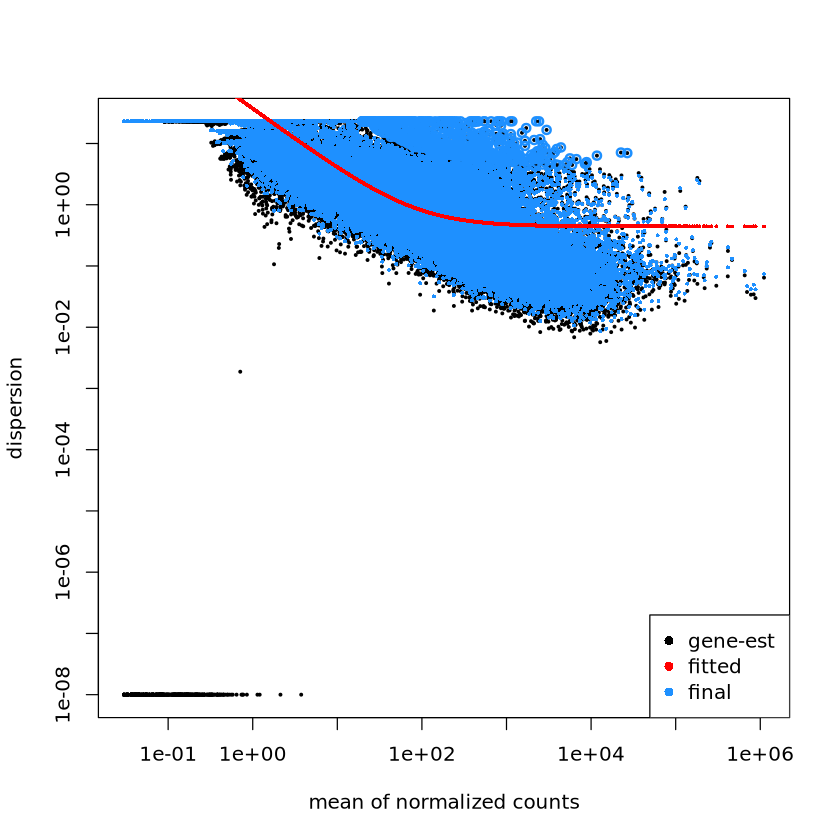

In [89]:
plotDispEsts(dds)

### comparisons vs. control
applying `ashr` lfc shrinkage estimator - DESeq docs recommend `apeglm` but cannot use that for comparisons below so I want everything to be consistent

#### warm vs. control

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 72, 0.21%
LFC < 0 (down)     : 86, 0.25%
outliers [1]       : 839, 2.4%
low counts [2]     : 2649, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



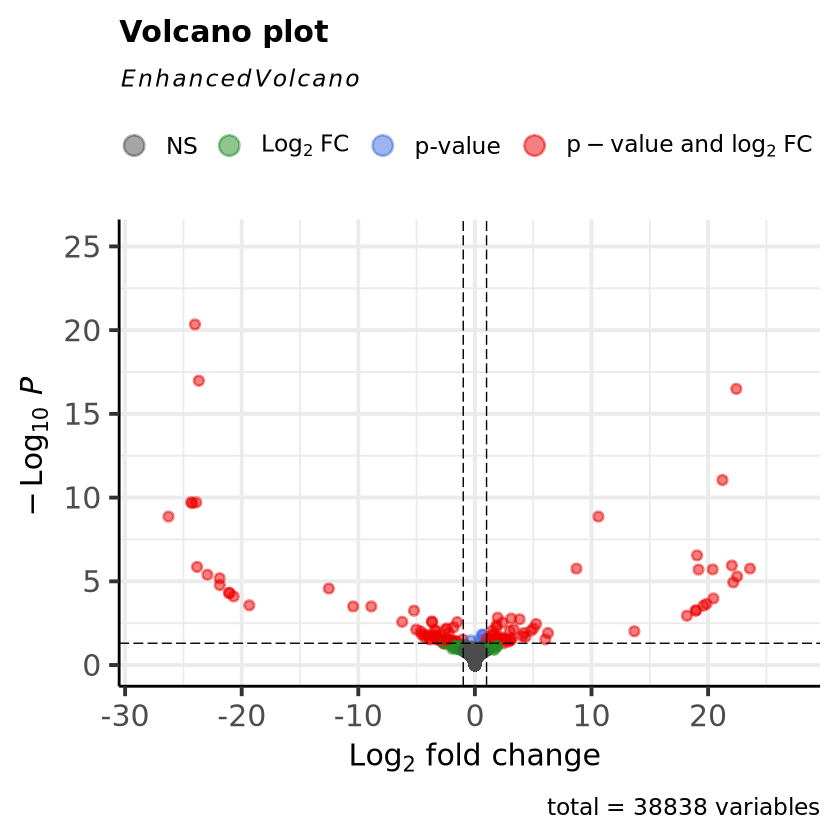

In [134]:
# phase 1 warm vs. control
res.warmLFC <- lfcShrink(dds, 
                         coef=4, 
                         type = 'ashr')

summary(res.warmLFC)

EnhancedVolcano(res.warmLFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [135]:
write.csv(as.data.frame(res.warmLFC), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_control.csv')

#### hypoxic vs. control

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 48, 0.14%
LFC < 0 (down)     : 27, 0.077%
outliers [1]       : 839, 2.4%
low counts [2]     : 675, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



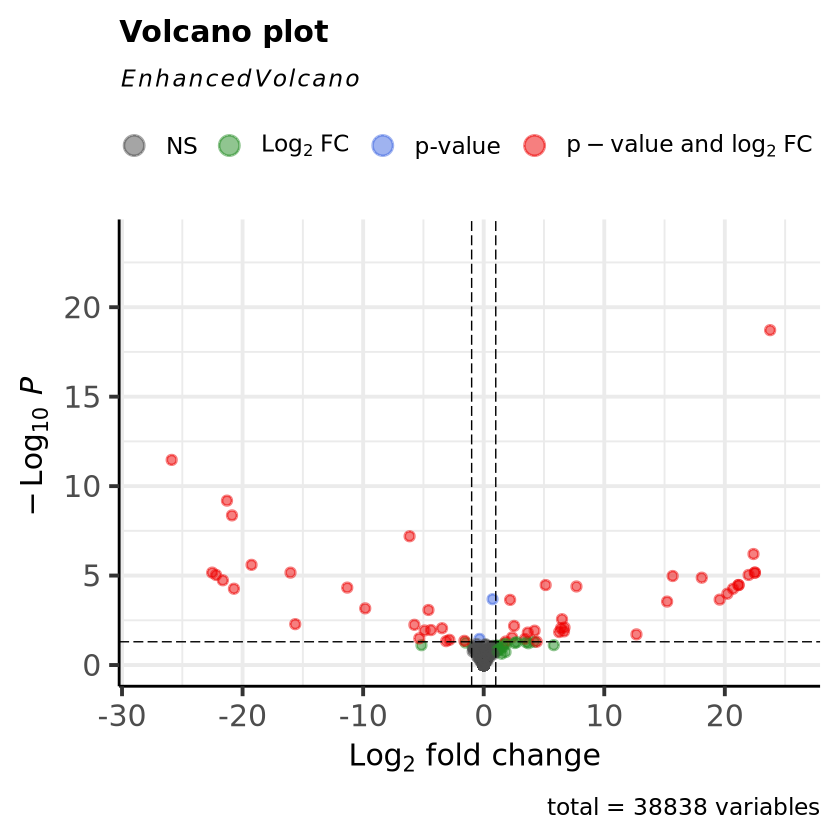

In [140]:
# phase 1 hypoxic vs. control
res.hypoxicLFC <- lfcShrink(dds, coef=3,type = 'ashr')

summary(res.hypoxicLFC)

EnhancedVolcano(res.hypoxicLFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [137]:
write.csv(as.data.frame(res.hypoxicLFC), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.hyp_v_control.csv')

#### both vs. control

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 138, 0.39%
LFC < 0 (down)     : 287, 0.82%
outliers [1]       : 839, 2.4%
low counts [2]     : 3262, 9.3%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



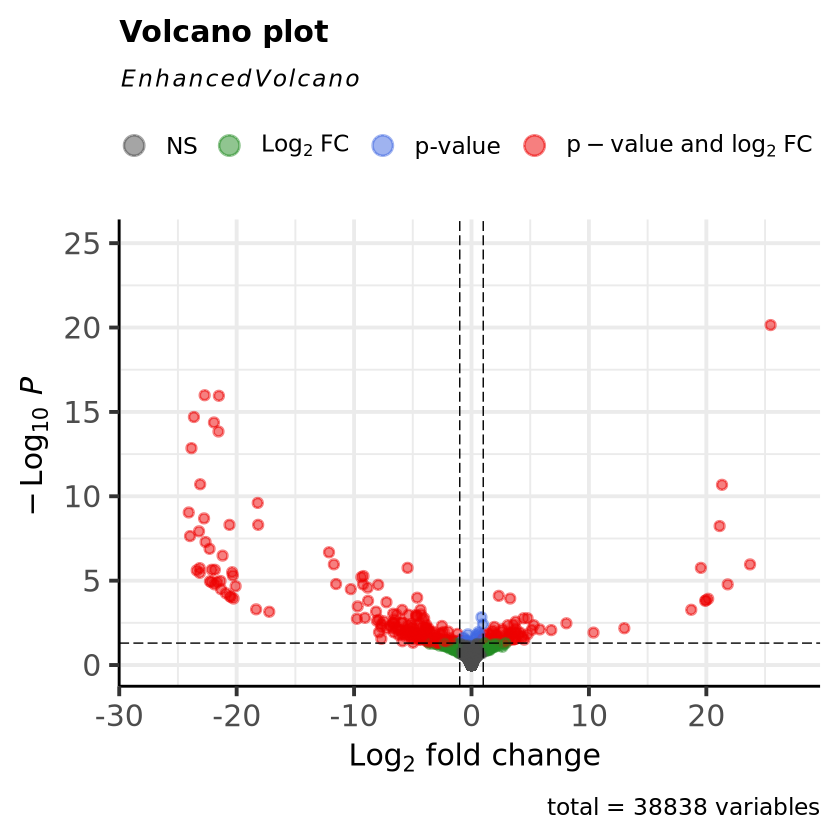

In [141]:
# phase 1 both vs. control
res.bothLFC <- lfcShrink(dds, coef=2, type = 'ashr')

summary(res.bothLFC)

EnhancedVolcano(res.bothLFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [142]:
write.csv(as.data.frame(res.bothLFC), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.both_v_control.csv')

### other comparisons
(outside of just doing treatment vs. control)

using `ashr` for lfc shrinkage estimator (same as above)

#### warm vs. hypoxic

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 109, 0.31%
LFC < 0 (down)     : 63, 0.18%
outliers [1]       : 839, 2.4%
low counts [2]     : 2015, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



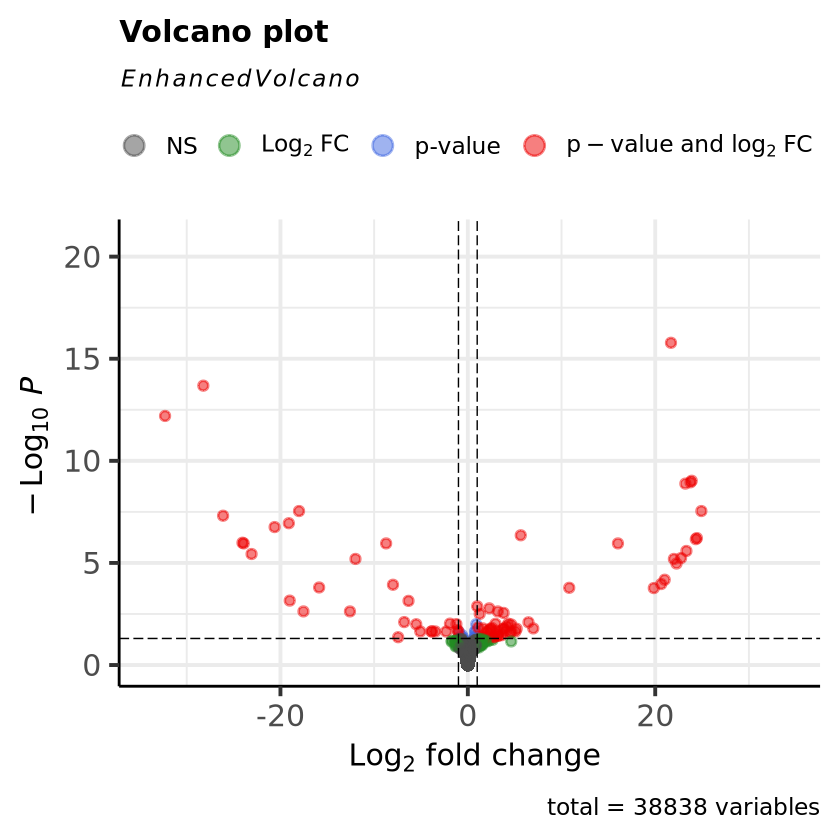

In [125]:
res.w.h <- lfcShrink(dds, contrast= c('Phase1_treatment', 'hypoxic', 'warm'), type = 'ashr')

summary(res.w.h)

EnhancedVolcano(res.w.h,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [128]:
write.csv(res.w.h, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_hyp.csv')

#### warm vs. both

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 154, 0.44%
LFC < 0 (down)     : 126, 0.36%
outliers [1]       : 839, 2.4%
low counts [2]     : 5130, 15%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



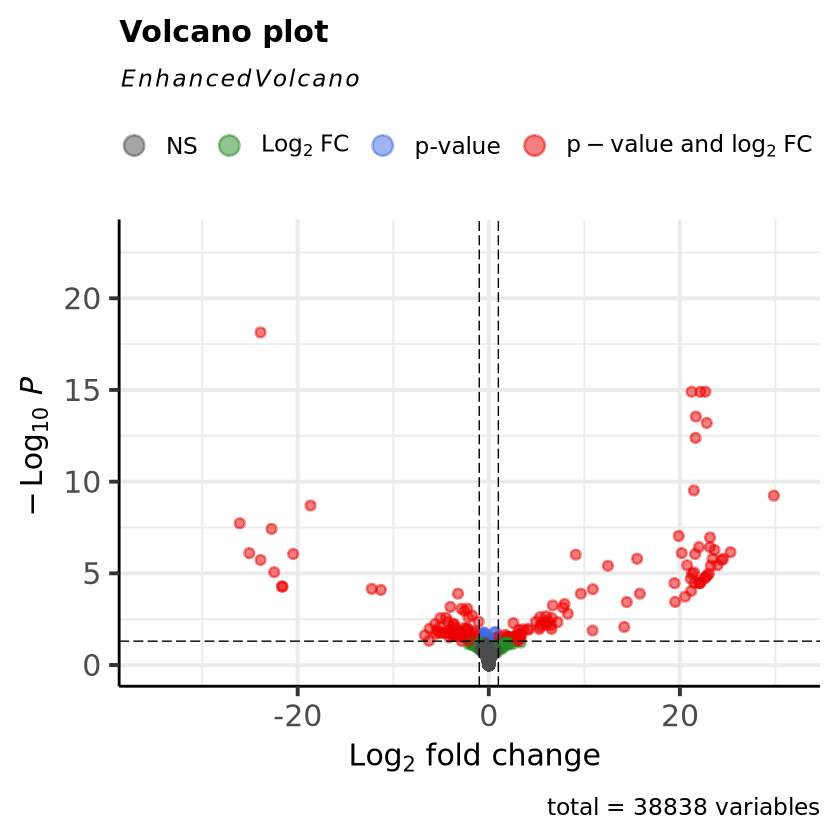

In [122]:
res.w.b <- lfcShrink(dds, contrast= c('Phase1_treatment', 'warm', 'both'), type = 'ashr')

summary(res.w.b)

EnhancedVolcano(res.w.b,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [129]:
write.csv(res.w.b, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.warm_v_both.csv')

#### hypoxic vs. both

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 34981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 213, 0.61%
LFC < 0 (down)     : 54, 0.15%
outliers [1]       : 839, 2.4%
low counts [2]     : 2649, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



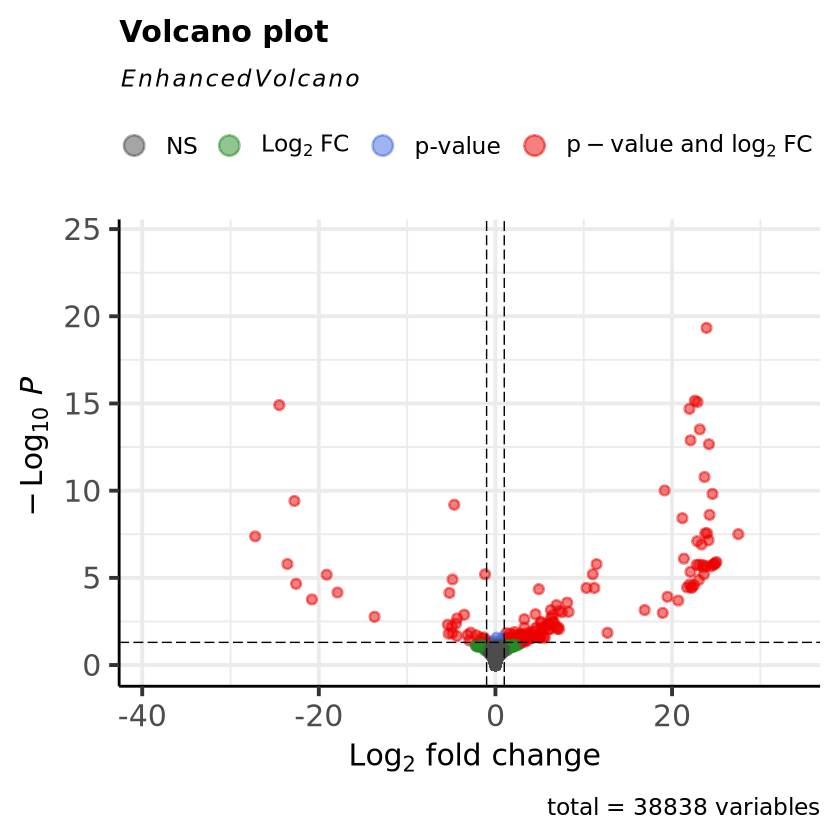

In [127]:
res.h.b <- lfcShrink(dds, contrast= c('Phase1_treatment', 'hypoxic', 'both'), type = 'ashr')

summary(res.h.b)

EnhancedVolcano(res.h.b,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [130]:
write.csv(res.h.b, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.hyp_v_both.csv')

## nMDS
normalize and transform DESeq object using csv (variance stabilized expression matrix)

In [98]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,B1_Nu_O03,B2_Nu_O12,B4_Nu_O32,B5_Nu_O36,B6_Nu_O47,C1_Nu_W01,C1_Nu_W05,C2_Nu_W15,C3_Nu_W21,C4_Nu_W29,⋯,H3_Nu_B18,H4_Nu_B28,H5_Nu_B35,H6_Nu_B45,W1_Nu_G02,W2_Nu_G15,W3_Nu_G21,W4_Nu_G27,W6_Nu_G41,W6_Nu_G45
B1_Nu_O03,0.0000,203.1140,195.1039,182.3211,173.9018,186.4840,185.8846,194.2911,181.2699,177.4347,⋯,211.8518,180.8692,178.8295,233.2292,191.3068,185.8885,174.1291,189.3901,169.0272,183.3507
B2_Nu_O12,203.1140,0.0000,178.3912,224.8518,213.4442,172.7770,194.9357,195.8964,191.0631,178.5330,⋯,186.3116,184.3246,214.6065,181.7933,184.5361,188.9821,190.1781,178.9019,210.4078,180.6837
B4_Nu_O32,195.1039,178.3912,0.0000,205.5049,198.6306,181.8347,181.4200,179.4273,178.7899,178.1022,⋯,189.0395,126.0233,199.5181,185.4816,176.9057,187.3434,192.8283,172.0237,209.2349,176.0272
B5_Nu_O36,182.3211,224.8518,205.5049,0.0000,172.5582,211.8919,193.3972,193.9310,186.4933,199.6367,⋯,225.9119,192.8199,179.2042,242.3882,195.0745,207.8053,212.5983,203.4372,198.4277,197.2967
B6_Nu_O47,173.9018,213.4442,198.6306,172.5582,0.0000,199.7950,189.8460,179.9627,183.4983,186.9331,⋯,205.7215,181.2779,173.4026,236.0590,179.8949,200.6794,201.7968,180.3279,186.0423,183.6095
C1_Nu_W01,186.4840,172.7770,181.8347,211.8919,199.7950,0.0000,182.8328,188.5758,183.8515,167.4244,⋯,187.1119,181.0015,204.9816,195.6153,172.3426,182.1973,183.9683,173.0938,196.0589,175.4917


,X1,X2,X,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,sizeFactor
,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>
B1_Nu_O03,63.80163,-38.906364,2,both,warm,hypoxic,1,NA,NA,NA,NA,1.1731259
B2_Nu_O12,-67.30304,-37.460503,6,both,warm,hypoxic,2,NA,NA,NA,NA,1.0498679
B4_Nu_O32,-35.37400,-3.668274,19,both,warm,hypoxic,4,NA,NA,NA,NA,1.1954800
B5_Nu_O36,88.64184,18.765606,25,both,warm,hypoxic,5,NA,NA,NA,NA,0.8890653
B6_Nu_O47,73.26232,9.041074,30,both,warm,hypoxic,6,NA,NA,NA,NA,0.9604278
C1_Nu_W01,-36.51973,-43.335119,35,control,ambient,normoxic,1,NA,NA,NA,NA,1.1472252


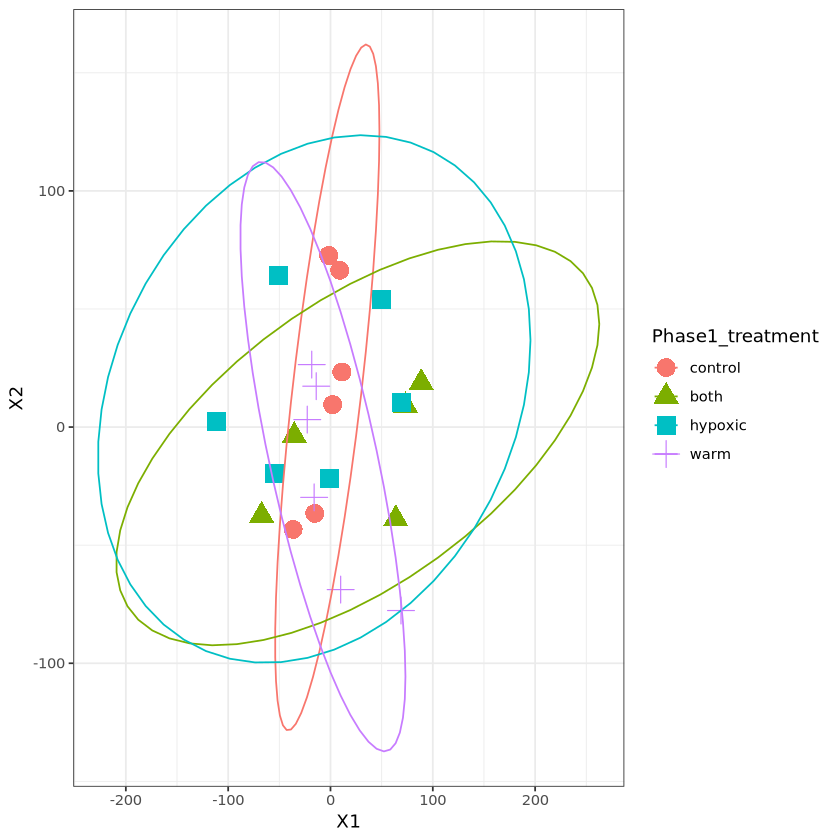

In [104]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase1_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

There doesn't appear to be any strong patterns of gene expression among the different phase 1 treatments

#### permANOVA

In [105]:
# distance matrix
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

# metadata
meta <- as.data.frame(colData(vsd))
head(meta)

[1] 203.1140 195.1039 182.3211 173.9018 186.4840 185.8846

,X,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,sizeFactor
,<int>,<fct>,<fct>,<fct>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>
B1_Nu_O03,2,both,warm,hypoxic,1,NA,NA,NA,NA,1.1731259
B2_Nu_O12,6,both,warm,hypoxic,2,NA,NA,NA,NA,1.0498679
B4_Nu_O32,19,both,warm,hypoxic,4,NA,NA,NA,NA,1.1954800
B5_Nu_O36,25,both,warm,hypoxic,5,NA,NA,NA,NA,0.8890653
B6_Nu_O47,30,both,warm,hypoxic,6,NA,NA,NA,NA,0.9604278
C1_Nu_W01,35,control,ambient,normoxic,1,NA,NA,NA,NA,1.1472252


In [109]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO, data = meta, permutations = 999)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phase1_temp,1,20561.28,0.05217778,1.1451747,0.208
Phase1_DO,1,17149.43,0.04351964,0.9551496,0.524
Phase1_temp:Phase1_DO,1,15211.77,0.03860248,0.8472301,0.777
Residual,19,341139.46,0.86570010,NA,NA
Total,22,394061.94,1.00000000,NA,NA


permANOVA confirms that there isn't any statistically significant differences in gene expression patterns among phase 1 treatments 

## heatmap

In [115]:
library(pheatmap)

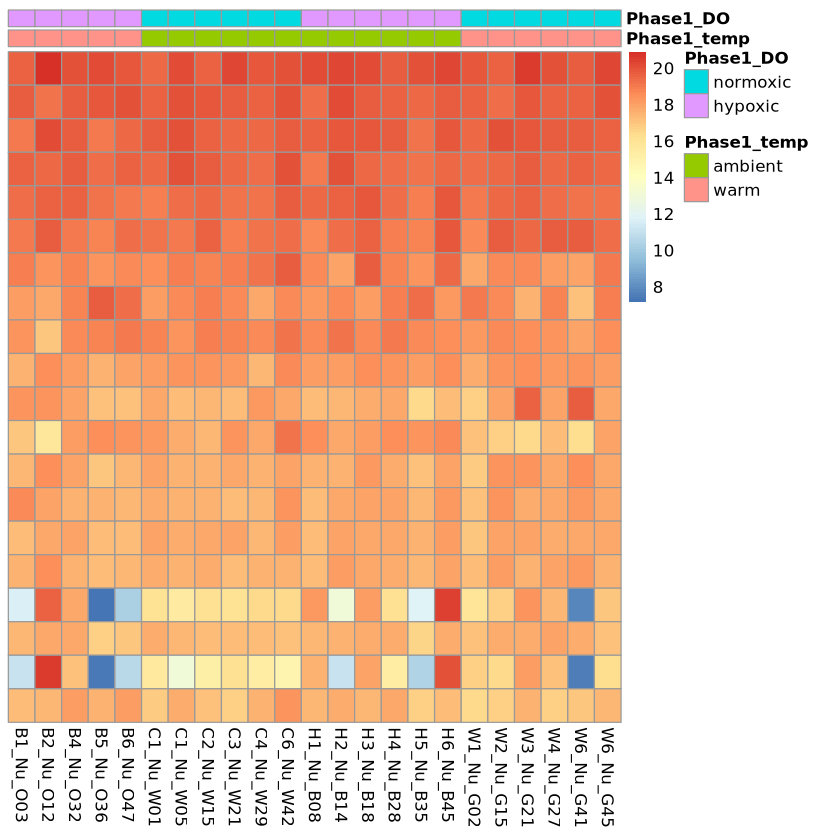

In [118]:
df <- as.data.frame(colData(dds)[,c("Phase1_temp","Phase1_DO")])
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]

pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)